# K-means no dataset Iris

* Pré-processamento
* Seleção de métrica
* Treinamento
* Seleção do $k$

Carregando os dados

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np


SEED = 42
np.random.seed(SEED)

data, target = load_iris(return_X_y=True, as_frame=True)
y_train = pd.DataFrame(target)

data.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Pré-processamento

Para evitar distorções nos cálculos de similaridade, é importante normalizar os atributos contínuos

In [2]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(data)

## Seleção de métrica

Como todos os atributos são contínuos, é possível utilizar a distância euclidiana que é a métrica padrão (não personalizável no momento) do KMeans implementado pelo SKLearn

In [3]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

samples_idx = np.random.randint(X_train.shape[0], size=2)
samples = X_train[samples_idx]

dist_matrix = euclidean_distances(samples, samples)

print("Matriz de distâncias entre dois pontos aleatórios: ")
print(dist_matrix)

Matriz de distâncias entre dois pontos aleatórios: 
[[0.         2.42873336]
 [2.42873336 0.        ]]


## Treinamento

Como o dataset Iris possui 3 classes, podemos verificar se os grupos encontrados pelo Kemeans conrespondem as classes esperadas.

In [4]:
y_train.shape

(150, 1)

/home/huber/projects/ml-studies/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


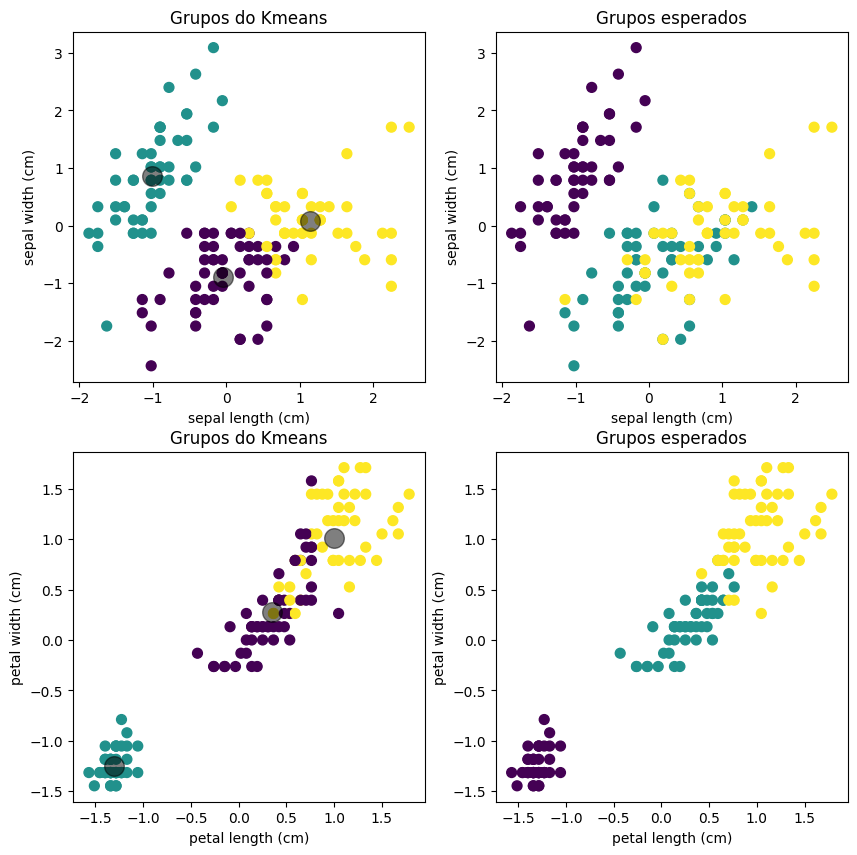

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

model = KMeans(n_clusters=3, random_state=SEED)

model.fit(X_train)
y_kmeans = model.predict(X_train)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# TODO: manter o mesmo esquema de cor para plots dos mesmos atributos
for i in range(2):
    ax[i][0].scatter(X_train[:, i << 1], X_train[:, i << 1 | 1], c=y_kmeans, s=50, cmap='viridis')
    ax[i][0].title.set_text(f"Grupos do Kmeans")
    ax[i][0].set_xlabel(data.columns[i << 1])
    ax[i][0].set_ylabel(data.columns[i << 1 | 1])
    centers = model.cluster_centers_
    ax[i][0].scatter(centers[:, i << 1], centers[:, i << 1 | 1], c='black', s=200, alpha=0.5)

    ax[i][1].scatter(X_train[:, i << 1], X_train[:, i << 1 | 1], c=y_train.values.T[0], s=50, cmap='viridis')
    ax[i][1].title.set_text(f"Grupos esperados")
    ax[i][1].set_xlabel(data.columns[i << 1])
    ax[i][1].set_ylabel(data.columns[i << 1 | 1])

Visualmente podemos ver que nem todos os pontos classificados pelos grupos do KMEans correspondem à classe esperada.

O algoritmo é sensível a inicialização dos clusters, para mitigar este problema, podemos aumentar o número de tentativas (parâmetro `n_init`) que o algoritmo realizará com difenretes inicializações de clsuters (valor padrão 10).

Porém, em vez de comparar visualmente cada resultado, podemos utilizar a métrica SSE (Sum of Squared Errors) e selecionar a execução que possui o menor erro.

$$SSE = \sum_{i-1}^{n} {(y_i - f(x_i))}^2$$

A métrica $SSE$ é calculada em relação a cada ponto e sua centróide, ou seja, se o algoritmo convergir corretamente, teremos o valor mais baixo possível, pois o cluster estará no centro daquele grupo, dessa forma, estando de acordo com a premissa do algoritmo.

Em resumo, vamos variar o parâmetro `n_init` e verificar se há variação no $SSE$.

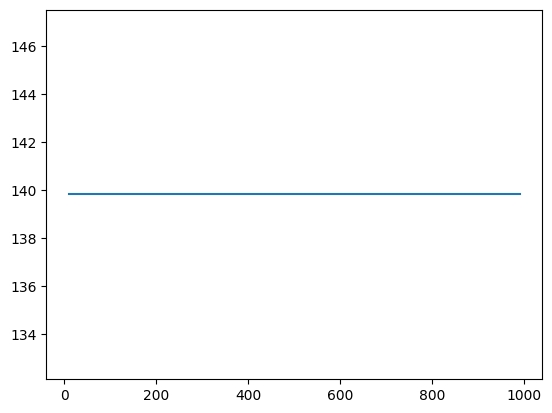

In [6]:
sse = []
rng = range(10, 1_000, 10)
for i in rng:
    model = KMeans(n_clusters=3, random_state=SEED, n_init=i)
    model.fit(X_train)
    sse.append(model.inertia_)

plt.plot(rng, sse)

Podemos ver que não há variação nos resultados, ou seja, podemos ter mais confiança de que a inicialização não está sendo um problema para o KMeans. Dessa forma, podemos descartar este hiperparâmetro e analisar os próximos.

Além deste, temos:

* Método de inicialização `init`: podendo ser "k-means++" ou "random". O segundo atribuir pontos aleatórios para cada cluster, o primeiro utiliza o algoritmo [greedy k-means++](https://dl.acm.org/doi/10.5555/1283383.1283494) que busca gerar as centróides iniciais de forma iterativa, maximizando a distância das centróides.
* Máximo de iterações `max_iter`: padrão é 300
* Tolerância `tol`: padrão é $1e-4$. Entre iterações, se a centróide variar abaixo desta tolerância, o algoritmo é parado.

Nenhum destes parâmetros parece influenciar o resultado, dessa forma, o ideal seria comparar o Kmeans com outros algoritmos de agrupamento e verificar a métrica $SSE$ (métricas internas).

> Como estamos utilizando um dataset que possui labels, podemos comparar diferentes métodos de agrupamento com base em métricas de classificação, pois, neste caso, temos o rótulo da classe esperada.

## Seleção do $k$

Um dos desafios é a seleção do $k$, ou seja, quantos grupos devemos utilizar no conjunto de dados. Com o dataset Iris, sabemos previamente que possuímos 3 classes, então fica claro o $k$ a ser utilizado, contudo, no mundo real não saberemos o $k$ de antemão.

Dessa forma, podemos utilizar o método do cotovelo (*elbow method*). Este método consiste em iterar por valores de $k$, terinar o algoritmo, armazenar a métrica $SSE$ e analisar o formato de "cotovelo" no gráfico. Espera-se que quando o método encontrar o melhor $k$, a $SSE$ irá diminuir drásticamente e as próximas iterações não terão erros significativamente menores (decaimento linear).

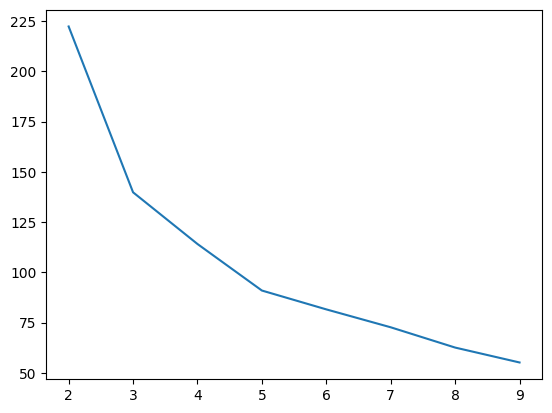

In [8]:
sse = []
rng = range(2, 10)
for i in rng:
    model = KMeans(n_clusters=i, random_state=SEED, n_init=10)
    model.fit(X_train)
    sse.append(model.inertia_)

plt.plot(rng, sse)

Neste caso, poderíamos escolher $k$ como 3, 4 ou ou até mesmo 5 a partir de 6 o decaimento aparenta ser linear, porém, será mesmo linear? Precisamos de mais pontos para analisar.

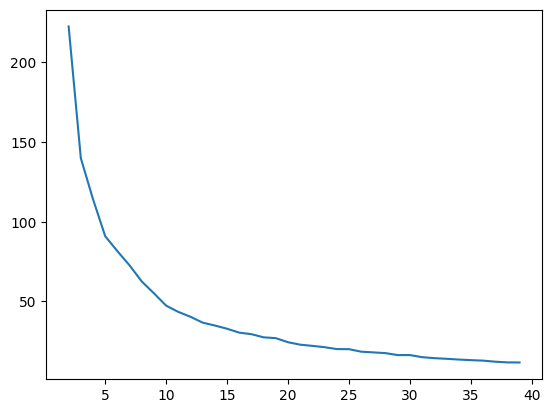

In [9]:
sse = []
rng = range(2, 40)
for i in rng:
    model = KMeans(n_clusters=i, random_state=SEED, n_init=10)
    model.fit(X_train)
    sse.append(model.inertia_)

plt.plot(rng, sse)

Agora podemos ver que até o ponto 20 (aproximadamente) o decaimento não é linear, ou seja, agora adionamos mais pontos que poderiam ser o ponto do cotovelo. Como escolher?

Vale relembrar que $SSE$ mede a distância de todos os pontos em relação as suas respectivas centróides. Contudo, se adicionarmos centróides o suficiente, podemos encontrar quantos quiseremos e o erro será cada vez menor, pois cada centróide terá um número menor de pontos.

Como uma análise complementar, podemos utilizar o [coeficiente de silhueta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) que, além de medir o quão próximos os pontos estão de suas centróides (como a $SSE$ faz), também mensura o quão distante os pontos estão em relação aos pontos de outros clusters. 
O índice varia de -1 à 1, onde 1 indica que os exemplos estão mais próximos de suas centróides do que de outras e -1 é o inverso.

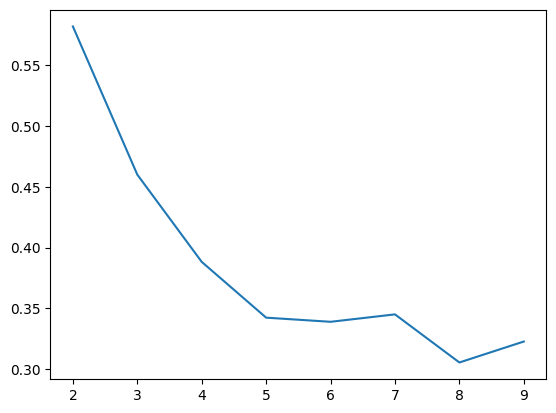

In [12]:
from sklearn.metrics import silhouette_score
silhouette_coefficients  = []
rng = range(2, 10)
for i in rng:
    model = KMeans(n_clusters=i, random_state=0, n_init=10)
    model.fit(X_train)
    silhouette_coefficients.append(silhouette_score(X_train, model.labels_))

plt.plot(rng, silhouette_coefficients)

Neste caso, utilizar $k=2$ produziu o melhor resultado, o que é diferente do esperado. Novamente, esta é uma das dificuldades conhecidas do agrupamento não supervisionado.